# DATA PREPARATION

## Donwload and Extract the data

In [4]:
import urllib.request

url = "https://www.ais.uni-bonn.de/deep_learning/LabelMe-12-50k.tar.gz"
filename = "LabelMe-12-50k.tar.gz"

urllib.request.urlretrieve(url, filename)
print("✅ Download complete")

✅ Download complete


In [5]:
import tarfile

with tarfile.open("LabelMe-12-50k.tar.gz", "r:gz") as tar:
    tar.extractall("LabelMe-12-50k")
print("✅ Extraction complete")

C:\Users\glori\AppData\Local\Temp\ipykernel_27876\2444416617.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("LabelMe-12-50k")


✅ Extraction complete


## Create a custom dataset class

In [8]:
!pip install torch torchvision torchaudio
!pip install matplotlib scikit-learn pillow numpy

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.2/204.1 MB 4.8 MB/s eta 0:00:43
   ---------------------------------------- 1.1/204.1 MB 13.4 MB/s eta 0:00:16
   ---------------------------------------- 2.4/204.1 MB 19.0 MB/s eta 0:00:11
    --------------------------------------- 4.4/204.1 MB 25.4 MB/s eta 0:00:08
   - -------------------------------------- 6.4/204.1 MB 29.3 MB/s eta 0:00:07
   - -------------------------------------- 9.1/204.1 MB 34.0 MB/s eta 0:00:06
   -- ------------------------------------- 10.7/204.1 MB 43.7 MB/s eta 0:00:05
   -- ------------------------------------- 13.2/204.1 MB 50.4 MB/s eta 0:00:04
   --- ------------------------------------ 16.6/204.1 MB 59.5 MB/s eta 0:00:04
   --- ------------------------------------ 18.5/204.1 MB 59.5 MB/s eta 0:00:04
   ---- ----------------------------------- 21.0/204.1 MB 54.4 MB/s eta 0:

In [ ]:
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
class LabelMeDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform

        self.data = []
        with open(annotation_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                img_id = parts[0]  # e.g., 000001
                labels = np.clip(np.array(parts[1:], dtype=np.float32), 0.0, 1.0)
                folder_id = f"{int(img_id)//1000:04d}"  # folder is 0000, 0001, ...
                img_path = os.path.join(image_dir, folder_id, f"{img_id}.jpg")
                self.data.append((img_path, labels))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, labels = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, labels


In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

base_path = r"C:\Users\glori\Desktop\Research Computing Environments\LabelMe-12-50k"

train_dataset = LabelMeDataset(
    image_dir=os.path.join(base_path, "train"),
    annotation_file=os.path.join(base_path, "train", "annotation.txt"),
    transform=transform
)

test_dataset = LabelMeDataset(
    image_dir=os.path.join(base_path, "test"),
    annotation_file=os.path.join(base_path, "test", "annotation.txt"),
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

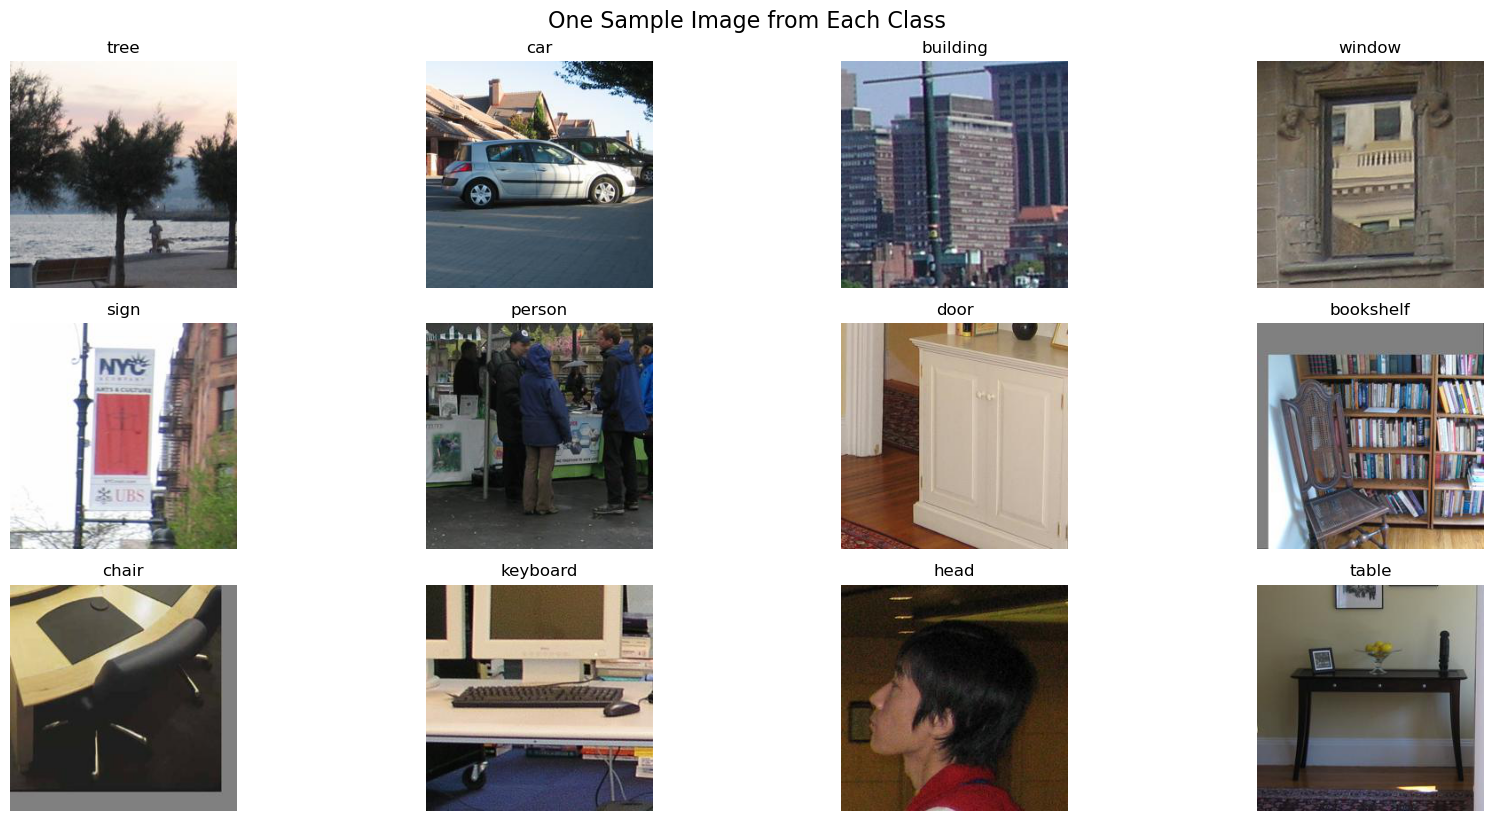

In [44]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import random

class_names = [
    "person", "car", "building", "window", "tree", "sign",
    "door", "bookshelf", "chair", "table", "keyboard", "head"
]

base_path = r"C:\Users\glori\Desktop\Research Computing Environments\LabelMe-12-50k\train"  

# Find one image for each class based on annotation file
annotation_path = os.path.join(base_path, "annotation.txt")

# Load lines from annotation file
with open(annotation_path, 'r') as f:
    lines = f.readlines()

# Pick one image per class
picked_images = {}
for line in lines:
    name, *scores = line.strip().split()
    scores = list(map(float, scores))

    for i, val in enumerate(scores):
        if val == 1.0 and class_names[i] not in picked_images:
            # Find which subfolder the image is in
            for folder in os.listdir(base_path):
                subdir = os.path.join(base_path, folder)
                if os.path.isdir(subdir):
                    image_path = os.path.join(subdir, f"{name}.jpg")
                    if os.path.exists(image_path):
                        picked_images[class_names[i]] = image_path
                        break
    if len(picked_images) == len(class_names):
        break  

plt.figure(figsize=(18, 8))
for idx, (label, path) in enumerate(picked_images.items()):
    img = Image.open(path)
    plt.subplot(3, 4, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("One Sample Image from Each Class", fontsize=16, y=1.02)
plt.show()


# Build and Train a CNN Model (Multi-Label Classification)

We’ll use a pre-trained ResNet18 as the base model, fine-tune it, and add:

- 12 output nodes (1 for each class)

- Sigmoid activation (since multiple labels can be active)



## Define the Model

In [25]:
class LabelMeClassifier(nn.Module):
    def __init__(self, num_classes=12):
        super(LabelMeClassifier, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Sequential(
            nn.Linear(self.base.fc.in_features, num_classes),
            nn.Sigmoid()  # Multi-label output
        )

    def forward(self, x):
        return self.base(x)

create an instance

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LabelMeClassifier().to(device)

Loss Function and Optimizer

In [27]:
criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [28]:
def train(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [29]:
train(model, train_loader, criterion, optimizer, device, epochs=5)

Epoch [1/5], Loss: 0.0519
Epoch [2/5], Loss: 0.0327
Epoch [3/5], Loss: 0.0259
Epoch [4/5], Loss: 0.0211
Epoch [5/5], Loss: 0.0168


In [30]:
torch.save(model.state_dict(), "labelme_resnet18_weights.pth")
print("✅ Model weights saved")

✅ Model weights saved


# Evaluation

### Reloading the model

In [10]:
import torch
import torch.nn as nn
from torchvision import models

# Re-define your model class
class LabelMeClassifier(nn.Module):
    def __init__(self, num_classes=12):
        super(LabelMeClassifier, self).__init__()
        self.base = models.resnet18(pretrained=True)
        self.base.fc = nn.Sequential(
            nn.Linear(self.base.fc.in_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.base(x)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LabelMeClassifier(num_classes=12).to(device)
model.load_state_dict(torch.load("labelme_resnet18_weights.pth"))
model.eval()  # Put the model in evaluation mode

c:\Users\glori\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\glori\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LabelMeClassifier(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

# Run Inference on the test set

In [12]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = (outputs > 0.5).float()  # threshold at 0.5

        y_true.append(labels.cpu())
        y_pred.append(preds.cpu())

y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()


## Accuracy and Classification Report

In [15]:
y_true_bin = (y_true > 0.5).astype(int)
y_pred_bin = (y_pred > 0.5).astype(int)

In [18]:
# percentage of images where all labels are predicted correctly
sample_accuracy = (y_true_bin == y_pred_bin).all(axis=1).mean()
print(f"Exact match accuracy: {sample_accuracy:.4f}")

Exact match accuracy: 0.9183


The model predicted all 12 labels perfectly for 91.83% of the test images

In [16]:
from sklearn.metrics import classification_report

class_names = [
    "person", "car", "building", "window", "tree", "sign",
    "door", "bookshelf", "chair", "table", "keyboard", "head"
]

print(classification_report(y_true_bin, y_pred_bin, target_names=class_names, zero_division=0))


              precision    recall  f1-score   support

      person       0.99      0.91      0.95      1244
         car       0.96      0.96      0.96       976
    building       0.84      0.73      0.78       535
      window       0.87      0.93      0.90      1029
        tree       0.92      0.84      0.88       504
        sign       0.93      0.72      0.81       252
        door       0.75      0.65      0.69       182
   bookshelf       1.00      0.68      0.81       100
       chair       0.83      0.62      0.71        88
       table       0.56      0.62      0.59        55
    keyboard       0.96      0.89      0.93        76
        head       0.84      0.92      0.88        50

   micro avg       0.92      0.87      0.89      5091
   macro avg       0.87      0.79      0.82      5091
weighted avg       0.92      0.87      0.89      5091
 samples avg       0.44      0.44      0.44      5091



The model achieved strong performance on the LabelMe-12-50k test set. It reached a micro-averaged F1-score of 0.89 and a macro-averaged F1-score of 0.82, indicating both overall effectiveness and balanced performance across classes. High F1-scores were seen for common classes like person (0.95), car (0.96), and window (0.90), showing that the model learned these categories well. Less frequent classes such as keyboard (0.93) and bookshelf (0.81) also performed well. However, classes like table (0.59) and chair (0.71) had lower scores, likely due to fewer examples and visual overlap with other categories. The samples-averaged F1-score was 0.44, which is typical in multi-label settings where full label matches are required per image. Overall, the model shows strong generalization with room for improvement in underrepresented categories.

## Confusion Matrix

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(y_true, y_pred, class_names):
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    axes = axes.flatten()

    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=axes[i], values_format='d', colorbar=False, cmap='Blues')
        axes[i].set_title(class_name)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    plt.tight_layout()
    plt.show()

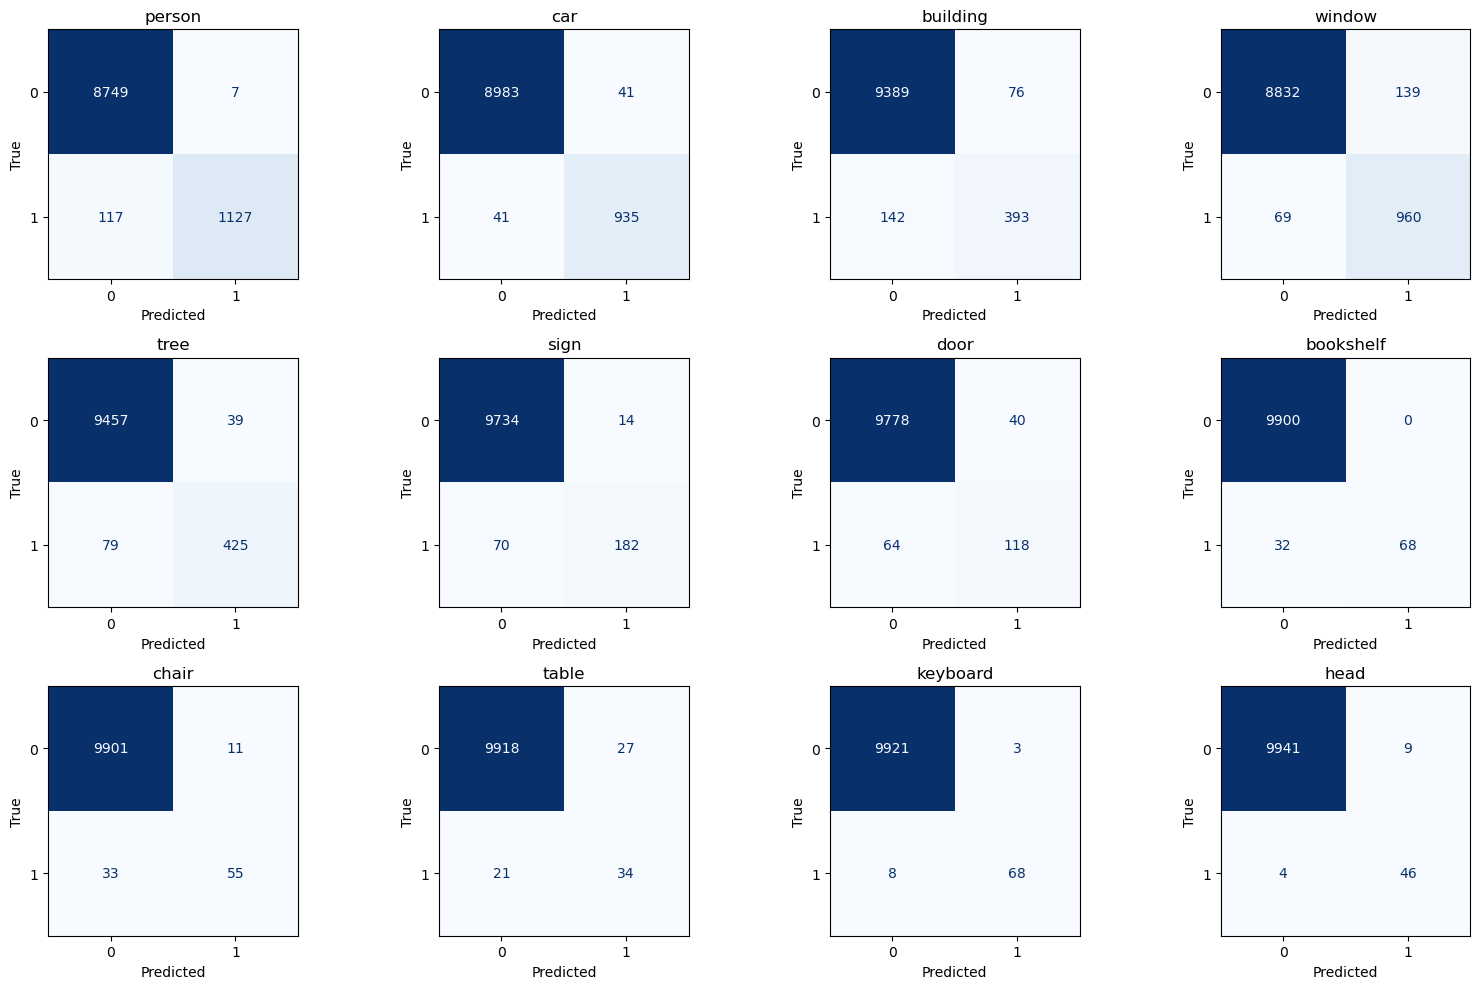

In [23]:
plot_confusion_matrices(y_true_bin, y_pred_bin, class_names)

## Visualizing Grad-CAM (Class Activation Mapping)

Grad-CAN uses the gradients flowing into the last convolutional layer of a CNN to produce a heatmap that highlights the most important regions in the image for a specific class prediction

In [24]:
!pip install torchcam

   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   -------------------------- ------------- 30.7/46.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 46.0/46.0 kB 761.8 kB/s eta 0:00:00


### Set Up Grad-CAM for ResNet18

In [25]:
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# Hook Grad-CAM to your model
cam_extractor = GradCAM(model.base, target_layer='layer4')  # Last conv layer in ResNet18

### Visualize Grad-CAM on One Image

In [32]:
def show_gradcam_topk(dataset, model, cam_extractor, index=0, top_k=3):
    model.eval()
    image, label = dataset[index]
    input_tensor = image.unsqueeze(0).to(device)  # Keep batch dimension

    # Forward pass to get scores
    scores = model(input_tensor).detach().cpu()  # shape [1, 12]

    # Get top-k predicted class indices
    top_classes = scores.squeeze(0).topk(top_k).indices.tolist()

    original_img = to_pil_image(image)

    for class_idx in top_classes:
        # Re-run forward pass to generate required gradients
        activation_map = cam_extractor(class_idx, model(input_tensor))

        # Overlay heatmap
        heatmap = overlay_mask(
            original_img,
            to_pil_image(activation_map[0].cpu(), mode='F'),
            alpha=0.5
        )

        plt.figure(figsize=(5, 5))
        plt.imshow(heatmap)
        plt.axis('off')
        score_val = scores[0, class_idx].item()
        plt.title(f"Top Grad-CAM: {class_names[class_idx]} (score: {score_val:.2f})")
        plt.show()


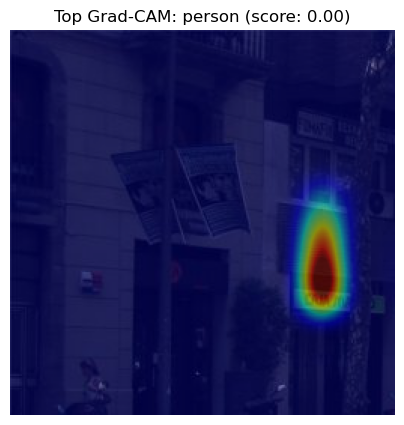

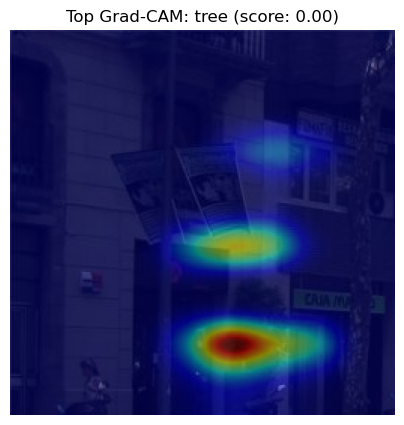

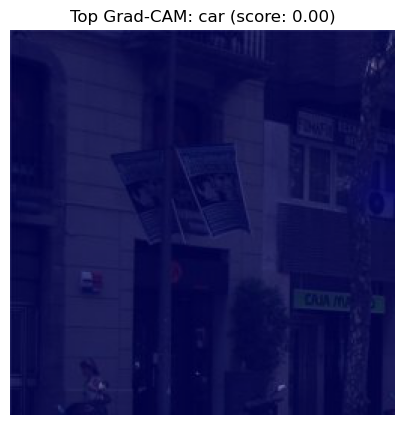

In [33]:
show_gradcam_topk(test_dataset, model, cam_extractor, index=42, top_k=3)

Grad-CAM visualizations were generated for the classes tree, person, and car on the same test image, each with a prediction confidence of 0.00. Despite the low prediction scores, the attention heatmaps revealed that the model still engaged in meaningful feature localization. 

- For the tree class, Grad-CAM highlighted vertical, textured areas resembling tree trunks, indicating the model's partial sensitivity to relevant spatial patterns. 

- In the case of person, the heatmap focused on a small figure near a doorway, suggesting that the model identified person-like features but did not assign sufficient confidence for classification. 

- For car, the attention was diffused, with little to no strong activation, implying that the model did not find compelling car-related features in the image. 

These results demonstrate that the model is capable of recognizing semantically relevant regions, even when it ultimately abstains from making a prediction. Such insights are valuable for understanding model uncertainty and can guide improvements in training through targeted data augmentation or confidence calibration.



### Auto-Generate and Save Grad-CAMs for Multiple Images

In [36]:
import os
import torch
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import matplotlib.pyplot as plt

# Folder to save Grad-CAM images
output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

def generate_and_save_gradcams(dataset, model, cam_extractor, class_names, top_k=1, num_samples=10, threshold=0.5):
    model.eval()

    for idx in range(num_samples):
        try:
            image, true_label = dataset[idx]
            input_tensor = image.unsqueeze(0).to(device)
            original_img = to_pil_image(image)

            # Enable gradients for Grad-CAM
            with torch.enable_grad():
                output = model(input_tensor).squeeze(0)  # shape [12]
                top_classes = output.topk(top_k).indices.tolist()

                for class_idx in top_classes:
                    # Get Grad-CAM heatmap for this class
                    activation_map = cam_extractor(class_idx, model(input_tensor))

                    # Overlay heatmap on original image
                    heatmap = overlay_mask(
                        original_img,
                        to_pil_image(activation_map[0].cpu(), mode='F'),
                        alpha=0.5
                    )

                    # Determine if prediction was correct for this class
                    predicted = output[class_idx].item() > threshold
                    actual = true_label[class_idx] > threshold
                    status = "correct" if predicted == actual else "incorrect"

                    # File naming
                    class_name = class_names[class_idx]
                    filename = f"{status}_{idx}_{class_name}.png"
                    heatmap.save(os.path.join(output_dir, filename))

                    print(f"✅ Saved: {filename}")

        except Exception as e:
            print(f"⚠️ Skipping index {idx} due to error: {e}")


In [37]:
# Create the CAM extractor
cam_extractor = GradCAM(model.base, target_layer="layer4")

# Generate Grad-CAMs
generate_and_save_gradcams(
    dataset=test_dataset,
    model=model,
    cam_extractor=cam_extractor,
    class_names=class_names,
    top_k=1,
    num_samples=10,
    threshold=0.5
)


✅ Saved: correct_0_car.png
✅ Saved: correct_1_car.png
✅ Saved: correct_2_car.png
✅ Saved: correct_3_car.png
✅ Saved: correct_4_table.png
✅ Saved: correct_5_car.png
✅ Saved: correct_6_car.png
✅ Saved: correct_7_window.png
✅ Saved: correct_8_car.png
✅ Saved: correct_9_car.png


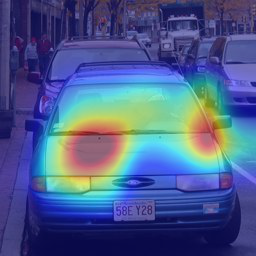

In [38]:
from IPython.display import Image, display

display(Image(filename="gradcam_outputs/correct_0_car.png"))


 **Grad-CAM visualization for the "car" class.**
 
The model accurately identified the car in the scene, with strong activation across the windshield, hood, and headlights — all characteristic features of the object. This heatmap confirms that the model is not relying on random background cues but instead focuses on semantically meaningful regions, demonstrating both visual interpretability and classification reliability.


In [39]:
def compare_gradcams(dataset, model, cam_extractor, index=0, class_indices=[0, 1]):
    image, _ = dataset[index]
    input_tensor = image.unsqueeze(0).to(device)
    original_img = to_pil_image(image)

    fig, axes = plt.subplots(1, len(class_indices), figsize=(6 * len(class_indices), 5))

    for i, class_idx in enumerate(class_indices):
        # Generate activation map
        activation_map = cam_extractor(class_idx, model(input_tensor))
        heatmap = overlay_mask(original_img, to_pil_image(activation_map[0].cpu(), mode='F'), alpha=0.5)

        axes[i].imshow(heatmap)
        axes[i].axis('off')
        axes[i].set_title(f"{class_names[class_idx]} (score: {model(input_tensor)[0, class_idx].item():.2f})")

    plt.tight_layout()
    plt.show()


In [41]:
from PIL import Image

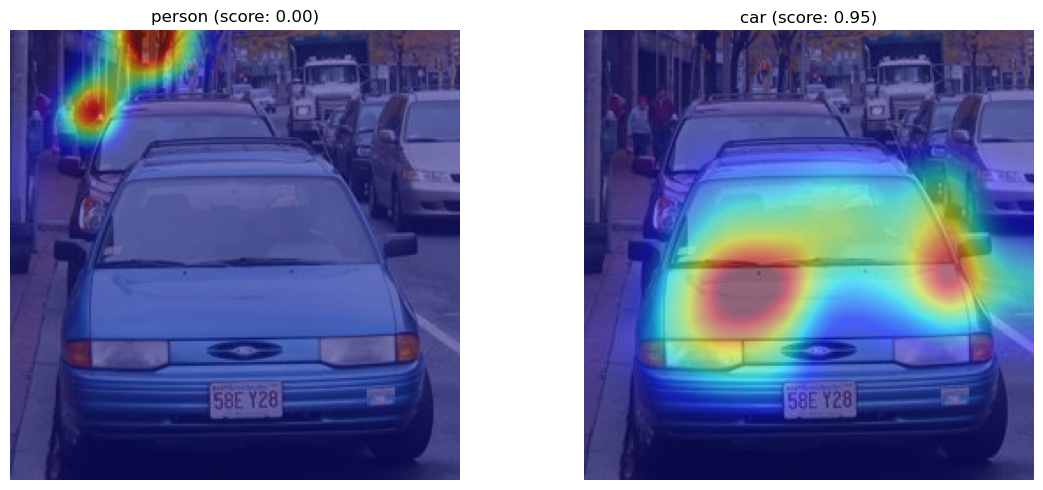

In [42]:
# Compare attention for "person" vs "car" on image 0
compare_gradcams(test_dataset, model, cam_extractor, index=0, class_indices=[0, 1])


Side-by-side Grad-CAM visualizations for “person” and “car” classes.

Although the model did not predict “person” (score: 0.00), it still localized regions where people are present, suggesting latent recognition. In contrast, the “car” class was confidently predicted (score: 0.95), with attention focused on the front of the vehicle, validating the model’s spatial understanding of object features.